# Bifurcation analysis

In [31]:
from functools import partial 
from collections import defaultdict 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.integrate
from mpl_toolkits.mplot3d import axes3d
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import sympy as sp
from sympy import latex
from scipy.optimize import fsolve, root
from IPython.display import display, Math
# %matplotlib inline

from potencial import get_expressions

plots_dir = 'plots/bifurcations/'

## Importing the functions and parameter definition
We're using for a start:

\begin{align}
c = 1, \quad g = 1, \quad s_0 = 1, \quad I_L = 1, \quad I_C = 1, \quad I_R = 1, \quad I_I = 1/3, \quad s_L = 0, \quad s_C = 0, \quad s_R = 0
\end{align}



In [39]:
X1, X2, I_L, I_C, I_R = sp.symbols('X1 X2 I_L I_C I_R')
values = {
    "tau": 0.1,
    "c": 1,
    "g": 1,
    "s0": 1,
    "IL": 1,
    "IC": 1,
    "IR": 1,
    "I_I": 1/3, # 1/4
    "sL": 0,
    "sC": 0,
    "sR": 0,
}
# If you want to substitute I_L, I_C, I_R, set substituted_I = True 
# type = symbolic to get the symbolic expressions
potencial, F1, F2, H = get_expressions(values, type = "symbolic", substituted_I =  False)

_,F1_num, F2_num, H_num = get_expressions(values, type = "numeric", substituted_I =  False)

display(Math(r"F1 = " + latex(F1)))
display(Math(r"F2 = " + latex(F2)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Definitions

In [33]:
EQUILIBRIUM_COLOR = {'Stable node':'C0',
                    'Unstable node':'C1', 
                    'Saddle':'C4',
                    'Stable focus':'C3',
                    'Unstable focus':'C2',
                    'Center':'C5',
                    'Transcritical (Saddle-Node)':'C6'}

STABILITY_STYLE = {
    "Stable node": "-",
    "Stable focus": "-",
    "Unstable node": "--",
    "Unstable focus": "--",
    "Saddle": ":",
    "Center": "-.",
    "Transcritical (Saddle-Node)": "-."
}

In [34]:
def stability(J):
    det = np.linalg.det(J)
    tr  = np.trace(J)
    if np.isclose(tr, 0) and np.isclose(det, 0):
        return "Center"
    elif np.isclose(det, 0):
        return "Transcritical (Saddle-Node)"
    elif det < 0:
        return "Saddle"
    else:
        base = "Stable" if tr < 0 else "Unstable"
        return base + (" focus" if (tr**2 - 4*det) < 0 else " node")
    
def vectorize_constant(f): # Needed to vectorize the function after lambdification
    def fv(x):
        y = f(x)
        if np.isscalar(y) or np.ndim(y)==0:
            return np.full_like(np.array(x, dtype=float), float(y), dtype=float)
        return np.array(y, dtype=float)
    return fv


## Computing the equilibrium points

We first find the equilibrium points for any given $\bar{I}$

In [35]:
I = sp.symbols('I')
F1_s = F1.subs({I_L: I, I_C: I, I_R: I})
F2_s = F2.subs({I_L: I, I_C: I, I_R: I})

soluciones = sp.solve([F1_s, F2_s], [X1, X2], dict=True)
soluciones

[{X1: 0.0, X2: 0.0},
 {X1: 0.0, X2: -1.83711730708738*sqrt(I + 0.226851851851852) - 0.875},
 {X1: 0.0, X2: 1.83711730708738*sqrt(I + 0.226851851851852) - 0.875},
 {X1: -2.63167095594496*sqrt(-0.000621576432523646*I**2 - 0.0204081632653061*I*(0.000927643784786642*I**2 + I + 0.247474747474747)**0.5 + 0.994936676326182*I + (0.000927643784786642*I**2 + I + 0.247474747474747)**0.5 + 0.497468338163091),
  X2: 0.0267857142857143*I + 0.879452954966893*sqrt(0.000927643784786642*I**2 + I + 0.247474747474747) + 0.4375},
 {X1: 2.63167095594496*sqrt(-0.000621576432523646*I**2 - 0.0204081632653061*I*(0.000927643784786642*I**2 + I + 0.247474747474747)**0.5 + 0.994936676326182*I + (0.000927643784786642*I**2 + I + 0.247474747474747)**0.5 + 0.497468338163091),
  X2: 0.0267857142857143*I + 0.879452954966893*sqrt(0.000927643784786642*I**2 + I + 0.247474747474747) + 0.4375},
 {X1: -2.63167095594496*sqrt(-0.000621576432523646*I**2 + 0.0204081632653061*I*(0.000927643784786642*I**2 + I + 0.247474747474747)**0

In [36]:
def find_equilibria(F1_num, F2_num, I_value,
                    initial_guesses=None,
                    tol=1e-6,
                    grid_limits=(-5,5),
                    grid_points=10):

    def system(vars):
        x1, x2 = vars
        return [
            F1_num(x1, x2, I_value, I_value, I_value),
            F2_num(x1, x2, I_value, I_value, I_value)
        ]

    if initial_guesses is None:
        a, b = grid_limits
        xs = np.linspace(a, b, grid_points)
        ys = np.linspace(a, b, grid_points)
        initial_guesses = [(x, y) for x in xs for y in ys]

    equilibria = []
    for guess in initial_guesses:
        sol = root(system, guess)
        if sol.success and np.allclose(sol.fun, [0, 0], atol=tol):
            x1_sol, x2_sol = sol.x
            if not any(np.hypot(x1_sol - x, x2_sol - y) < tol for x, y in equilibria):
                equilibria.append((x1_sol, x2_sol))

    return equilibria

Now we put the solutions on a list and compute the Jacobian to find the stability of the points

In [37]:
vec = sp.Matrix([F1_s, F2_s])
J   = vec.jacobian([X1, X2])

J_funcs = []
for sol in soluciones:
    Jsub = J.subs(sol)
    J_funcs.append([
        sp.lambdify(I, sp.simplify(Jsub[i,j]), 'numpy')
        for i in range(2) for j in range(2)
    ])

f1_list = [sp.lambdify(I, sol[X1], 'numpy') for sol in soluciones]
f2_list = [sp.lambdify(I, sol[X2], 'numpy') for sol in soluciones]


f1_list = [vectorize_constant(f) for f in f1_list]
f2_list = [vectorize_constant(f) for f in f2_list]


## Plots with stability

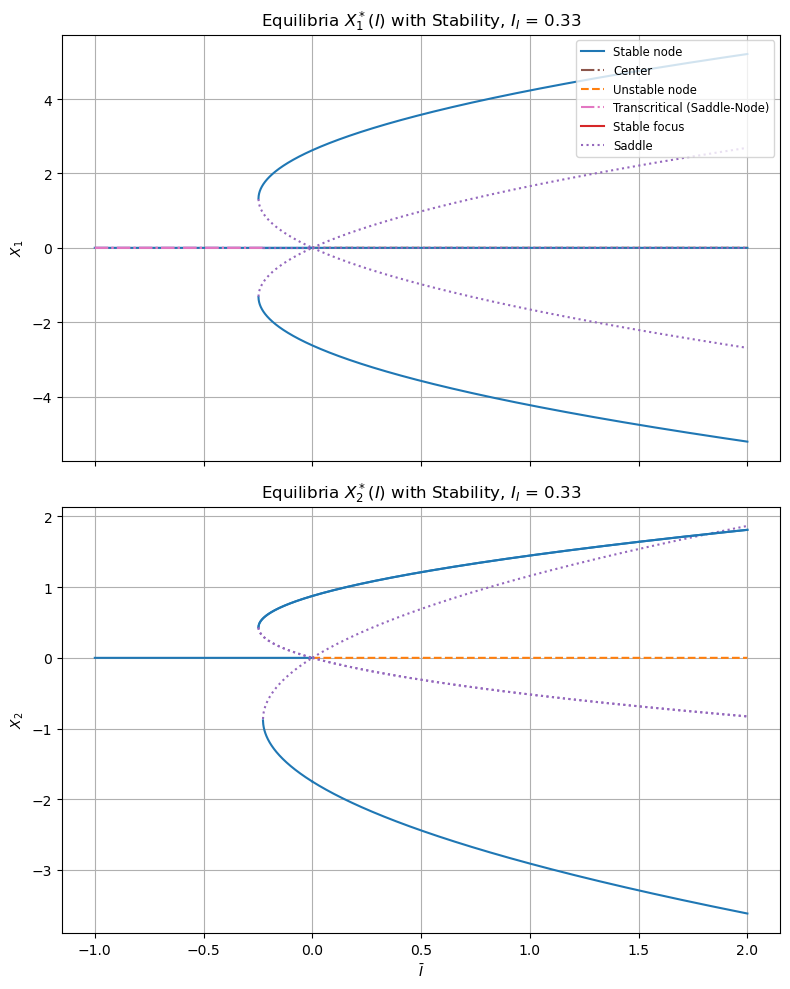

In [38]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

I_vals = np.linspace(-1, 2,10000)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

tasks = [
    (ax1, f1_list, '$X_1$', f'Equilibria $X_1^*(I)$ with Stability, $I_I$ = {values["I_I"]:.2f}'),
    (ax2, f2_list, '$X_2$', f'Equilibria $X_2^*(I)$ with Stability, $I_I$ = {values["I_I"]:.2f}'),
]

for ax, f_list, y_label, title in tasks:
    plotted = set()
    for idx, (f, jf) in enumerate(zip(f_list, J_funcs), 1):
        y = f(I_vals)
        stab = [ stability(
                    np.array([[g(Iv) for g in jf[:2]],
                              [g(Iv) for g in jf[2:]]], float)
                )
                for Iv in I_vals ]
        
        start = 0
        for i in range(1, len(I_vals)+1):
            if i == len(I_vals) or stab[i] != stab[start]:
                s   = stab[start]
                seg = slice(start, i)
                ax.plot(
                    I_vals[seg], y[seg],
                    linestyle=STABILITY_STYLE[s],
                    color=EQUILIBRIUM_COLOR[s],
                    lw=1.5,
                    label=(s if s not in plotted else '_nolegend_')
                )
                plotted.add(s)
                start = i

    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.grid(True)

ax2.set_xlabel(r'$\bar{I}$')
ax1.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.savefig(f'{plots_dir}equilibria_stability_I_I_{values["I_I"]:.2f}.png', dpi=500)
plt.show()